# PyTorch MrVI analysis over Tahoe100M cells dataset using LaminDB Custom Dataloader

MrVI (Multi-resolution Variational Inference) is a model for analyzing multi-sample single-cell RNA-seq data. 
This tutorial show how to do run MrVI in PyTorch version over the [Tahoe100M](https://doi.org/10.1101/2025.02.20.639398) cells dataset and perform basic analysis, using [Lamin](https://lamin.ai/) custom dataloader.


In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import gc
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import scvi.hub
import seaborn as sns
import torch
from scvi.dataloaders import MappedCollectionDataModule
from scvi.external import TorchMRVI as MRVI

run_autotune = False

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.0 is installed, but it is not compatible with the installed jaxlib version 0.6.2, so it will not be used.
  warnings.warn(


In [3]:
# import inspect
# print(inspect.getsource(MRVI))

In [4]:
# os.system("lamin init --storage ./lamindb_collection")
import lamindb as ln
# ln.setup.init()

→ connected lamindb: anonymous/lamindb_collection


In [5]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.3


In [6]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [7]:
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 1000)

## Get the data

We start by downloading the model from its hub in order to use its metadata
Note that the model is very large therefore it will take time to being download.

In [8]:
# get the hub data
tahoe_hubmodel = scvi.hub.HubModel.pull_from_huggingface_hub(
    repo_name="vevotx/Tahoe-100M-SCVI-v1", cache_dir="."
)

/tmp/ipykernel_837533/2427481814.py:2: UserWarning: No revision was passed, so the default (latest) revision will be used.
  tahoe_hubmodel = scvi.hub.HubModel.pull_from_huggingface_hub(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
tahoe_hubmodel.model.adata.obs.head()

INFO     Loading model...                                                                                          
INFO     File ./models--vevotx--Tahoe-100M-SCVI-v1/snapshots/b5283a73fbbed812a95264ace360da538b20af89/model.pt     
         already downloaded                                                                                        


,sample,species,gene_count,tscp_count,mread_count,bc1_wind,bc2_wind,bc3_wind,bc1_well,bc2_well,bc3_well,id,drugname_drugconc,drug,INT_ID,NUM.SNPS,NUM.READS,demuxlet_call,BEST.LLK,NEXT.LLK,DIFF.LLK.BEST.NEXT,BEST.POSTERIOR,SNG.POSTERIOR,SNG.BEST.LLK,SNG.NEXT.LLK,SNG.ONLY.POSTERIOR,DBL.BEST.LLK,DIFF.LLK.SNG.DBL,sublibrary,BARCODE,pcnt_mito,S_score,G2M_score,phase,pass_filter,dataset,_scvi_batch,_scvi_labels,_scvi_observed_lib_size,plate,Cell_Name_Vevo,Cell_ID_Cellosaur,observed_lib_size
BARCODE_SUB_LIB_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01_001_052-lib_1105,smp_1783,hg38,1878,2893,3284,1,1,52,A1,A1,E4,recgIHRi9MiCIr4CO,"[('8-Hydroxyquinoline', 0.05, 'uM')]",8-Hydroxyquinoline,1.0,199.0,215.0,singlet,-50.74,-59.04,8.30,-55.0,1.0,-50.74,-87.96,0.0,-59.04,8.30,lib_1105,01_001_052,0.019357,0.174603,0.179670,G2M,full,0,0,0,2893,4,PANC-1,CVCL_0480,2893
01_001_105-lib_1105,smp_1783,hg38,1765,2434,2764,1,1,105,A1,A1,p2.A9,recgIHRi9MiCIr4CO,"[('8-Hydroxyquinoline', 0.05, 'uM')]",8-Hydroxyquinoline,3.0,137.0,140.0,singlet,-37.97,-42.41,4.44,-43.0,1.0,-37.97,-64.52,0.0,-42.41,4.44,lib_1105,01_001_105,0.029581,0.297619,0.342857,G2M,full,0,0,0,2434,4,SW480,CVCL_0546,2434
01_001_165-lib_1105,smp_1783,hg38,3174,5691,6454,1,1,165,A1,A1,p2.F9,recgIHRi9MiCIr4CO,"[('8-Hydroxyquinoline', 0.05, 'uM')]",8-Hydroxyquinoline,4.0,379.0,396.0,singlet,-129.66,-130.65,0.99,-130.0,1.0,-129.66,-186.89,0.0,-130.65,0.99,lib_1105,01_001_165,0.031629,0.031746,0.099084,G2M,full,0,0,0,5691,4,SW1417,CVCL_1717,5691
01_003_094-lib_1105,smp_1783,hg38,1380,1804,2050,1,3,94,A1,A3,H10,recgIHRi9MiCIr4CO,"[('8-Hydroxyquinoline', 0.05, 'uM')]",8-Hydroxyquinoline,7.0,122.0,125.0,singlet,-31.79,-33.98,2.19,-36.0,1.0,-31.79,-49.36,0.0,-33.98,2.19,lib_1105,01_003_094,0.017738,-0.063492,0.019780,G2M,full,0,0,0,1804,4,SW1417,CVCL_1717,1804
01_003_164-lib_1105,smp_1783,hg38,1179,1514,1715,1,3,164,A1,A3,p2.F8,recgIHRi9MiCIr4CO,"[('8-Hydroxyquinoline', 0.05, 'uM')]",8-Hydroxyquinoline,8.0,87.0,93.0,singlet,-28.99,-27.07,-1.92,-34.0,1.0,-28.99,-41.61,0.0,-27.07,-1.92,lib_1105,01_003_164,0.023118,-0.075397,-0.070879,G1,full,0,0,0,1514,4,A498,CVCL_1056,1514


In [10]:
# Load Cell Line Metadata
cell_lines = pd.read_csv(
    "/home/access/PycharmProjects/scvi-tools/Tahoe100M/cell_line_metadata.h5ad"
)
cell_lines.head()

,Unnamed: 0,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
0,0,A549,ACH-000681,CVCL_0023,Lung,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
1,1,A549,ACH-000681,CVCL_0023,Lung,CDKN2B,Hom,Deletion,DEL,LoF,Suppressor
2,2,A549,ACH-000681,CVCL_0023,Lung,KRAS,Hom,Missense,p.G12S,GoF,Oncogene
3,3,A549,ACH-000681,CVCL_0023,Lung,SMARCA4,Hom,Frameshift,p.Q729fs,LoF,Suppressor
4,4,A549,ACH-000681,CVCL_0023,Lung,STK11,Hom,Stopgain,p.Q37*,LoF,Suppressor


In the next part we are creating artifacts from a subset of 1M cells per plate (and 5 plates) from the dataset and unite them to a collection. Artifacts and collections are the ways lamindb interactes with the data.
From this point forward we will not use adatas again.
The tutorial assumed those files were already ready (see for how to [here](https://huggingface.co/datasets/tahoebio/Tahoe-100M/blob/main/tutorials/loading_data.ipynb))

In [11]:
# Init Lamin instance
ln.track()

→ loaded Transform('GMYJf4FqDHnZ0000'), re-started Run('5FGprgCv...') at 2025-08-12 08:55:01 UTC
• recommendation: to identify the notebook across renames, pass the uid: ln.track("GMYJf4FqDHnZ")


In [12]:
# We make a collection of artifactos from files that are stored on disk
artifact1 = ln.Artifact.from_anndata(
    "/home/access/PycharmProjects/scvi-tools/Tahoe100M/tahoe100m_sample_1000000_plate1.h5ad",
    key="part_1.h5ad",
).save()
artifact2 = ln.Artifact.from_anndata(
    "/home/access/PycharmProjects/scvi-tools/Tahoe100M/tahoe100m_sample_1000000_plate2.h5ad",
    key="part_2.h5ad",
).save()
artifact3 = ln.Artifact.from_anndata(
    "/home/access/PycharmProjects/scvi-tools/Tahoe100M/tahoe100m_sample_1000000_plate3.h5ad",
    key="part_3.h5ad",
).save()
artifact4 = ln.Artifact.from_anndata(
    "/home/access/PycharmProjects/scvi-tools/Tahoe100M/tahoe100m_sample_1000000_plate4.h5ad",
    key="part_4.h5ad",
).save()
artifact5 = ln.Artifact.from_anndata(
    "/home/access/PycharmProjects/scvi-tools/Tahoe100M/tahoe100m_sample_1000000_rand.h5ad",
    key="part_5.h5ad",
).save()

! calling anonymously, will miss private instances
→ returning existing artifact with same hash: Artifact(uid='sBdR09Afz0MqbLu50002', is_latest=True, key='part_1.h5ad', suffix='.h5ad', kind='dataset', otype='AnnData', size=17933581240, hash='fmr6LyB4ySH0Q7vA_zCZMy', n_observations=1000000, branch_id=1, space_id=1, storage_id=1, run_id=2, created_by_id=1, created_at=2025-08-07 13:24:38 UTC); to track this artifact as an input, use: ln.Artifact.get()
→ returning existing artifact with same hash: Artifact(uid='6PuwYTVC0rc8ik9h0002', is_latest=True, key='part_2.h5ad', suffix='.h5ad', kind='dataset', otype='AnnData', size=19205241784, hash='Kd0DjdW_GFI2QXzeaFePJ2', n_observations=1000000, branch_id=1, space_id=1, storage_id=1, run_id=2, created_by_id=1, created_at=2025-08-07 13:24:49 UTC); to track this artifact as an input, use: ln.Artifact.get()
→ returning existing artifact with same hash: Artifact(uid='Y4Ht6CkaiGsXWWTJ0000', is_latest=True, key='part_3.h5ad', suffix='.h5ad', kind='datas

In [13]:
collection = ln.Collection([artifact1, artifact2, artifact3, artifact4, artifact5], key="gather")
collection.save()

! returning existing collection with same hash: Collection(uid='6IASvDXmFbji3Uzu000Q', is_latest=True, key='gather', hash='5K17S6WOKo9udA6RiGW4Lw', branch_id=1, space_id=1, created_by_id=1, run_id=2, created_at=2025-08-07 13:25:33 UTC); if you intended to query to track this collection as an input, use: ln.Collection.get()


Collection(uid='6IASvDXmFbji3Uzu000Q', is_latest=True, key='gather', hash='5K17S6WOKo9udA6RiGW4Lw', branch_id=1, space_id=1, created_by_id=1, run_id=2, created_at=2025-08-07 13:25:33 UTC)

In [14]:
# We load the collection to see it consists of many h5ad files
artifacts = collection.artifacts.all()
artifacts.df()

,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,branch_id
id,,,,,,,,,,,,,,,,,,,,,,,
39,sBdR09Afz0MqbLu50002,part_1.h5ad,None,.h5ad,dataset,AnnData,17933581240,fmr6LyB4ySH0Q7vA_zCZMy,None,1000000,sha1-fl,True,False,1,1,None,None,True,2,2025-08-07 13:24:38.913000+00:00,1,None,1
40,6PuwYTVC0rc8ik9h0002,part_2.h5ad,None,.h5ad,dataset,AnnData,19205241784,Kd0DjdW_GFI2QXzeaFePJ2,None,1000000,sha1-fl,True,False,1,1,None,None,True,2,2025-08-07 13:24:49.589000+00:00,1,None,1
41,Y4Ht6CkaiGsXWWTJ0000,part_3.h5ad,None,.h5ad,dataset,AnnData,15146243320,f3_p_AkcSfh-P2aKlmOkeC,None,1000000,sha1-fl,True,False,1,1,None,None,True,2,2025-08-07 13:25:00.960000+00:00,1,None,1
42,GBKhWVRoRltw7UZk0001,part_4.h5ad,None,.h5ad,dataset,AnnData,15207127144,rJLJdKpkSvkvB-ks7A2z3e,None,1000000,sha1-fl,True,False,1,1,None,None,True,2,2025-08-07 13:25:11.405000+00:00,1,None,1
43,NBFiWx43U3hNm4dR0001,part_5.h5ad,None,.h5ad,dataset,AnnData,17240836184,7RX84cxLdX92Sb9Cu74ZjF,None,1000000,sha1-fl,True,False,1,1,None,None,True,2,2025-08-07 13:25:20.940000+00:00,1,None,1


we can now define the batch and data loader which replaces the default AnnDataloder of and use that on MRVI model.

In [15]:
datamodule = MappedCollectionDataModule(
    collection,
    batch_key="plate",
    sample_key="sample",
    batch_size=1024,
    shuffle=True,
    join="inner",
    model_name="MRVI",
    collection_val=collection,
)

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationW

In [16]:
print(datamodule.n_obs, datamodule.n_vars, datamodule.n_batch)

5000000 62710 14


## Train mrVI with LaminDB

In [17]:
# Init the model
model = MRVI(registry=datamodule.registry)

/tmp/ipykernel_837533/2543352391.py:2: UserWarning: You are using the Torch Version of MrVI, starting v1.4, The Jax Version of MrVI is under the model called: JaxMrVI
  model = MRVI(registry=datamodule.registry)


In [18]:
# Training the model (for 5M cells will take 1 day+ with early stopping - better to cancel it)
import time

gc.collect()
start = time.time()
model.train(
    max_epochs=50,
    # early_stopping=True,
    plan_kwargs={"lr": 1e-3, "n_epochs_kl_warmup": 40},
    datamodule=datamodule,
    batch_size=1024,
    # early_stopping_patience=5,
    # check_val_every_n_epoch=1,
    # datasplitter_kwargs={
    #    "external_indexing": [np.array(train_ind), np.array(valid_ind)]
    # }
)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1024. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 832. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=50` reached.


Elapsed time: 76663.62 seconds


In [21]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

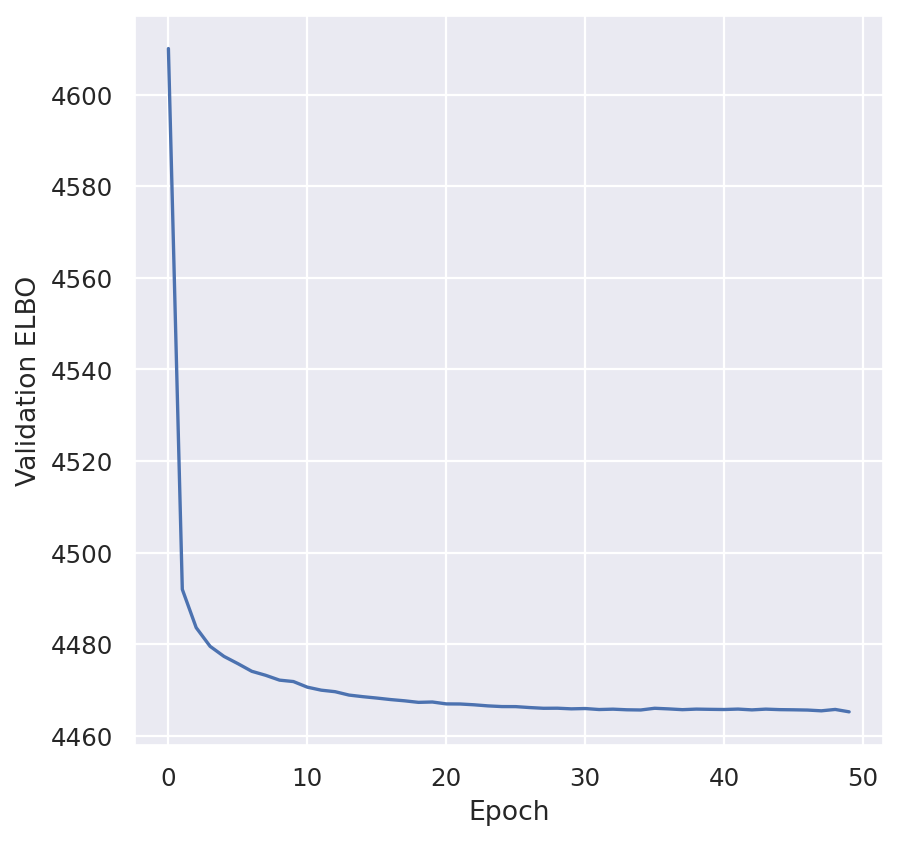

In [22]:
plt.plot(model.history["elbo_validation"])
plt.xlabel("Epoch")
plt.ylabel("Validation ELBO")
plt.show()

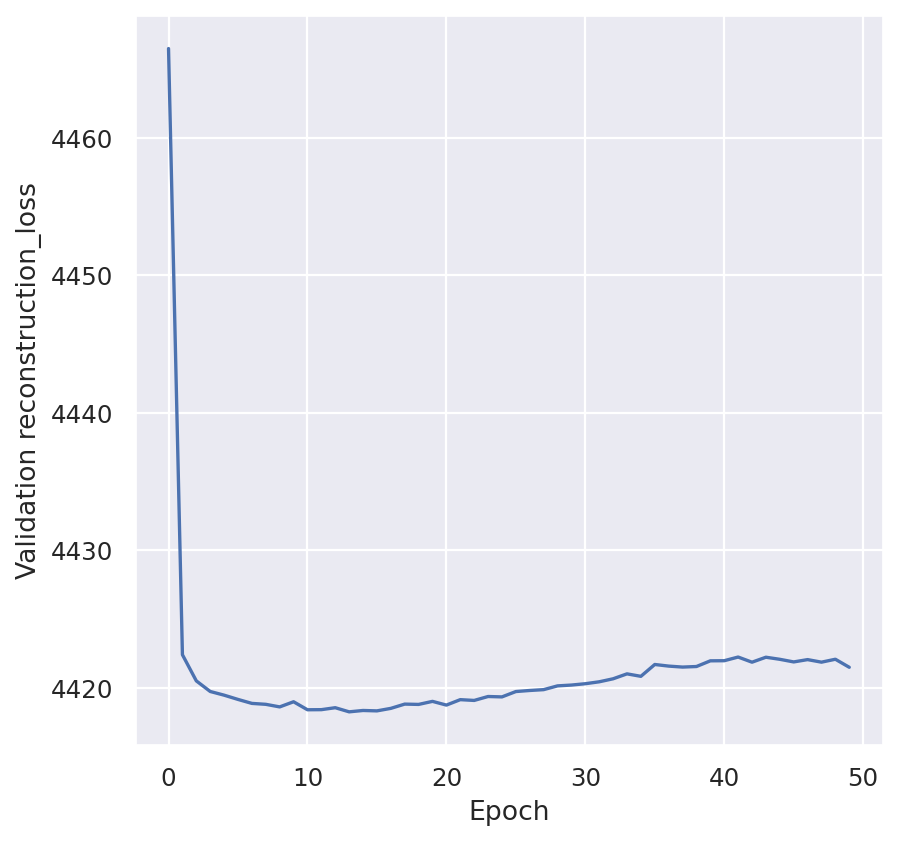

In [23]:
plt.plot(model.history["reconstruction_loss_validation"])
plt.xlabel("Epoch")
plt.ylabel("Validation reconstruction_loss")
plt.show()

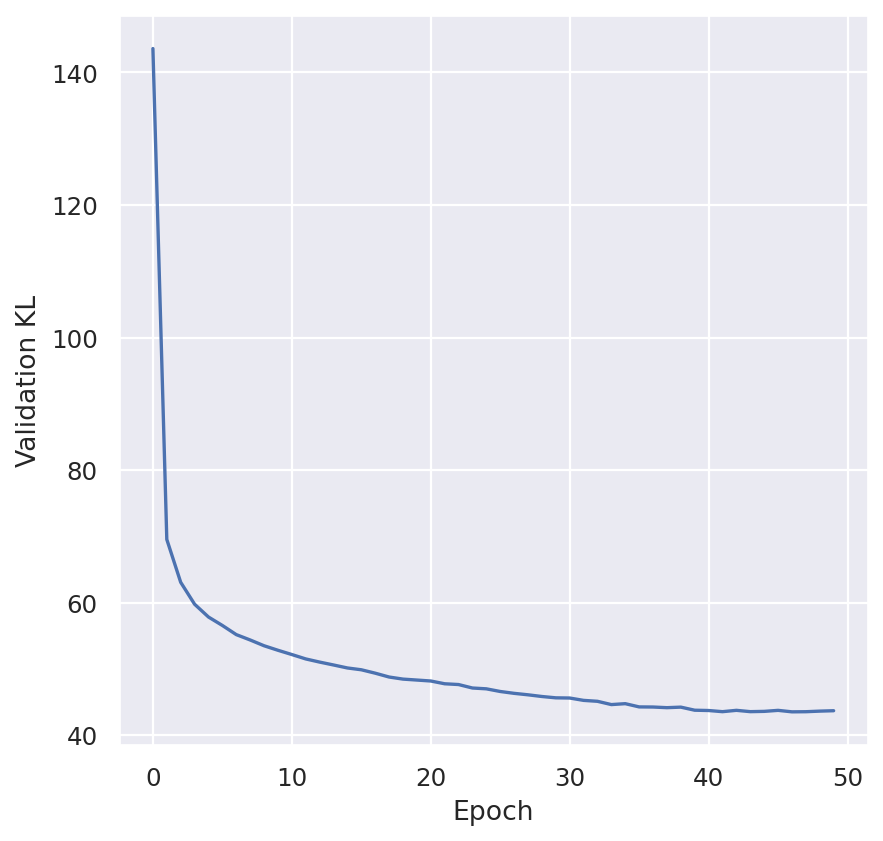

In [24]:
plt.plot(model.history["kl_local_validation"])
plt.xlabel("Epoch")
plt.ylabel("Validation KL")
plt.show()

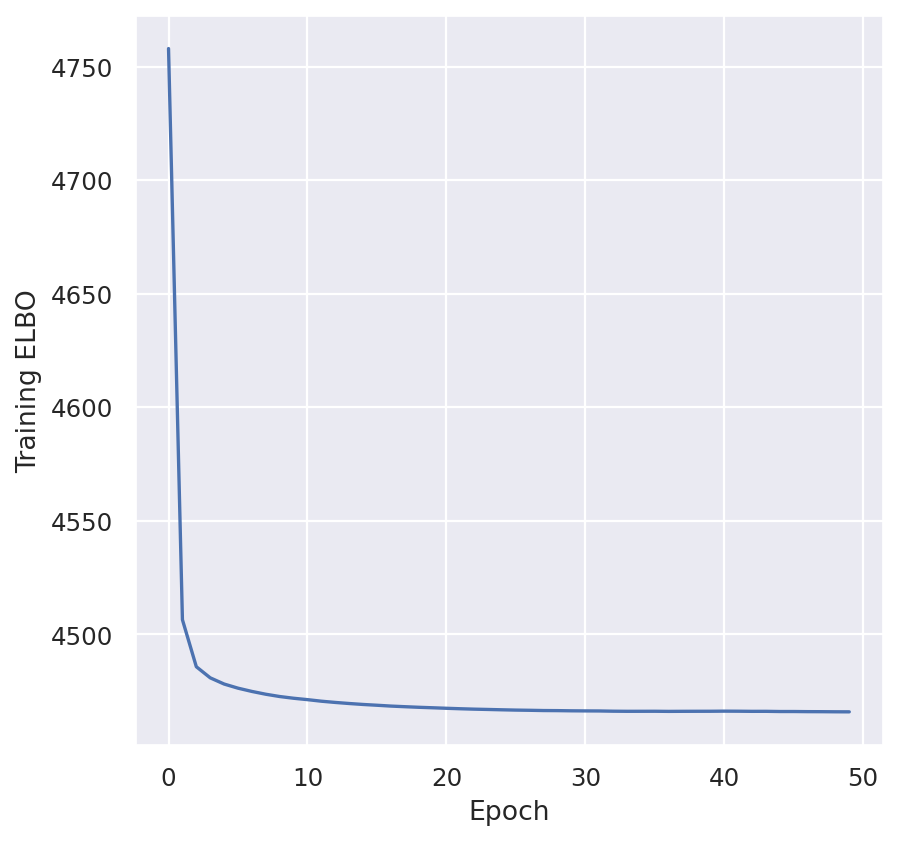

In [25]:
plt.plot(model.history["elbo_train"])
plt.xlabel("Epoch")
plt.ylabel("Training ELBO")
plt.show()

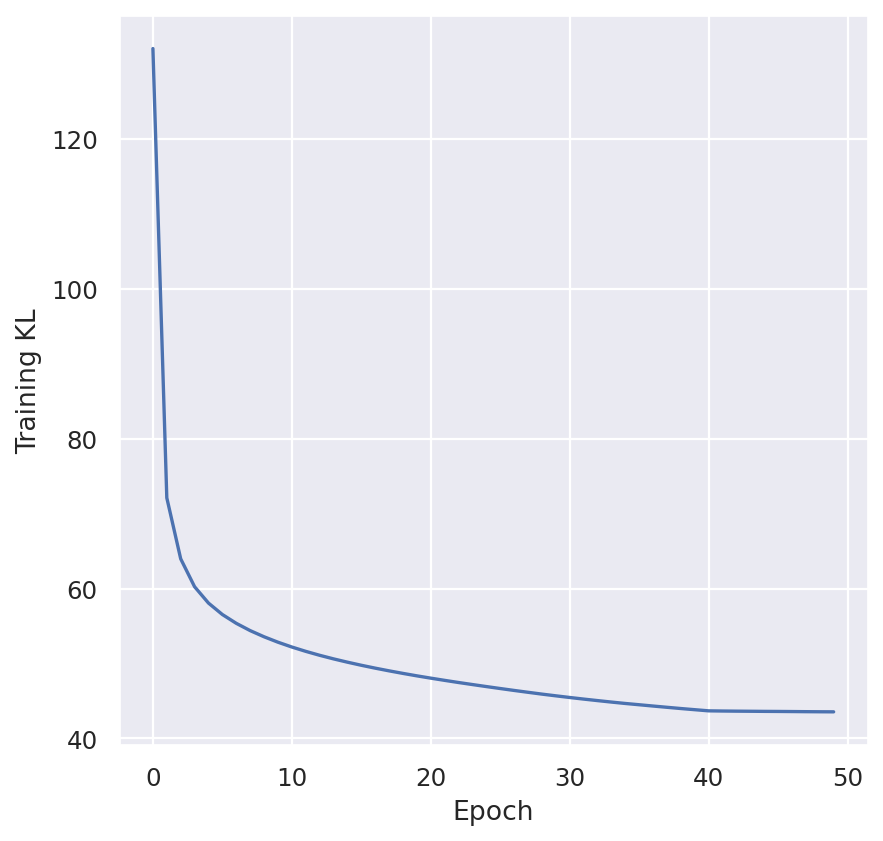

In [26]:
plt.plot(model.history["kl_local_train"])
plt.xlabel("Epoch")
plt.ylabel("Training KL")
plt.show()

In [27]:
# Save the model
model.save(
    "mrvi_torch_tahoe100_lamin_model", save_anndata=False, overwrite=True, datamodule=datamodule
)

In [18]:
# Load the model
# model = MRVI.load("mrvi_torch_tahoe100_lamin_model", adata=False)

INFO     File mrvi_torch_tahoe100_lamin_model/model.pt already downloaded                                          


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/model/base/_save_load.py:144: UserWarning: You are using the Torch Version of MrVI, starting v1.4, The Jax Version of MrVI is under the model called: JaxMrVI
  model = cls(adata, registry=registry, **non_kwargs, **kwargs)


In [80]:
# We extract the adata of the model, to be able to use it for plot umaps
# To save time we could also select a sub set of it
adata = collection.load(join="inner")
adata

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationW

AnnData object with n_obs × n_vars = 5000000 × 62710
    obs: 'drug', 'sample', 'BARCODE_SUB_LIB_ID', 'cell_line_id', 'moa-fine', 'canonical_smiles', 'pubchem_cid', 'plate', 'mean_gene_count', 'mean_tscp_count', 'mean_mread_count', 'mean_pcnt_mito', 'drugname_drugconc', 'targets', 'moa-broad', 'human-approved', 'clinical-trials', 'gpt-notes-approval', 'artifact_uid'

In [20]:
adata.obs.plate.value_counts()

plate
plate4     1141125
plate2     1084672
plate3     1056448
plate1     1028224
plate5      125045
plate10     112896
plate12     112896
plate11      84672
plate9       56450
plate7       56450
plate14      56448
plate6       28225
plate8       28225
plate13      28224
Name: count, dtype: int64

In [21]:
# merge metadata (will add memory)
# adata.obs = adata.obs.merge(tahoe_hubmodel.model.adata.obs[["Cell_Name_Vevo","dataset","phase","observed_lib_size","S_score","G2M_score","sublibrary"]], how='left', left_on='BARCODE_SUB_LIB_ID', right_index=True)

In [42]:
adata

AnnData object with n_obs × n_vars = 5000000 × 62710
    obs: 'drug', 'sample', 'BARCODE_SUB_LIB_ID', 'cell_line_id', 'moa-fine', 'canonical_smiles', 'pubchem_cid', 'plate', 'mean_gene_count', 'mean_tscp_count', 'mean_mread_count', 'mean_pcnt_mito', 'drugname_drugconc', 'targets', 'moa-broad', 'human-approved', 'clinical-trials', 'gpt-notes-approval', 'artifact_uid'

In [30]:
# In order to save memory for the sake of this tutorial we drop the count matrix from this adata (like done during minification)
from scipy.sparse import csr_matrix

del adata.raw
adata.X = csr_matrix(adata.X.shape)

In [59]:
# The way to extract the internal model analysis is by the inference_dataloader
# Datamodule will always require to pass it into all downstream functions.
inference_dataloader = datamodule.inference_dataloader(
    batch_size=1024, parallel_cpu_count=5, shuffle=False
)

In [82]:
gc.collect()

0

In [61]:
latent_representation = model.get_latent_representation(
    give_z=False, dataloader=inference_dataloader
)

In [62]:
latent_representation.shape

(5000000, 10)

We removed the count layer from the adata therefore we cant run PCA like before

In [63]:
# adata.layers["counts"] = adata.X.copy()  # preserve counts
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# adata.raw = adata  # freeze the state in `.raw`

In [64]:
# run PCA then generate UMAP plots
# sc.tl.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata, min_dist=0.1)

In [65]:
# sc.pl.umap(
#    adata,
#    color=["plate", "cell_line_id"],
#    ncols=2,
#    frameon=False,
# )

In [83]:
adata.obsm["X_mrVI_Torch_Lamin"] = latent_representation

In [67]:
# Subsample the adata to save time and memory
adata_subsampled = adata[
    list(np.random.choice(np.arange(adata.n_obs), size=100000, replace=False)), :
].copy()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [68]:
adata_subsampled.obsm["X_mrVI_Torch_Lamin"].shape

(100000, 10)

In [69]:
sc.pp.neighbors(adata_subsampled, use_rep="X_mrVI_Torch_Lamin")
sc.tl.umap(adata_subsampled, min_dist=0.3)

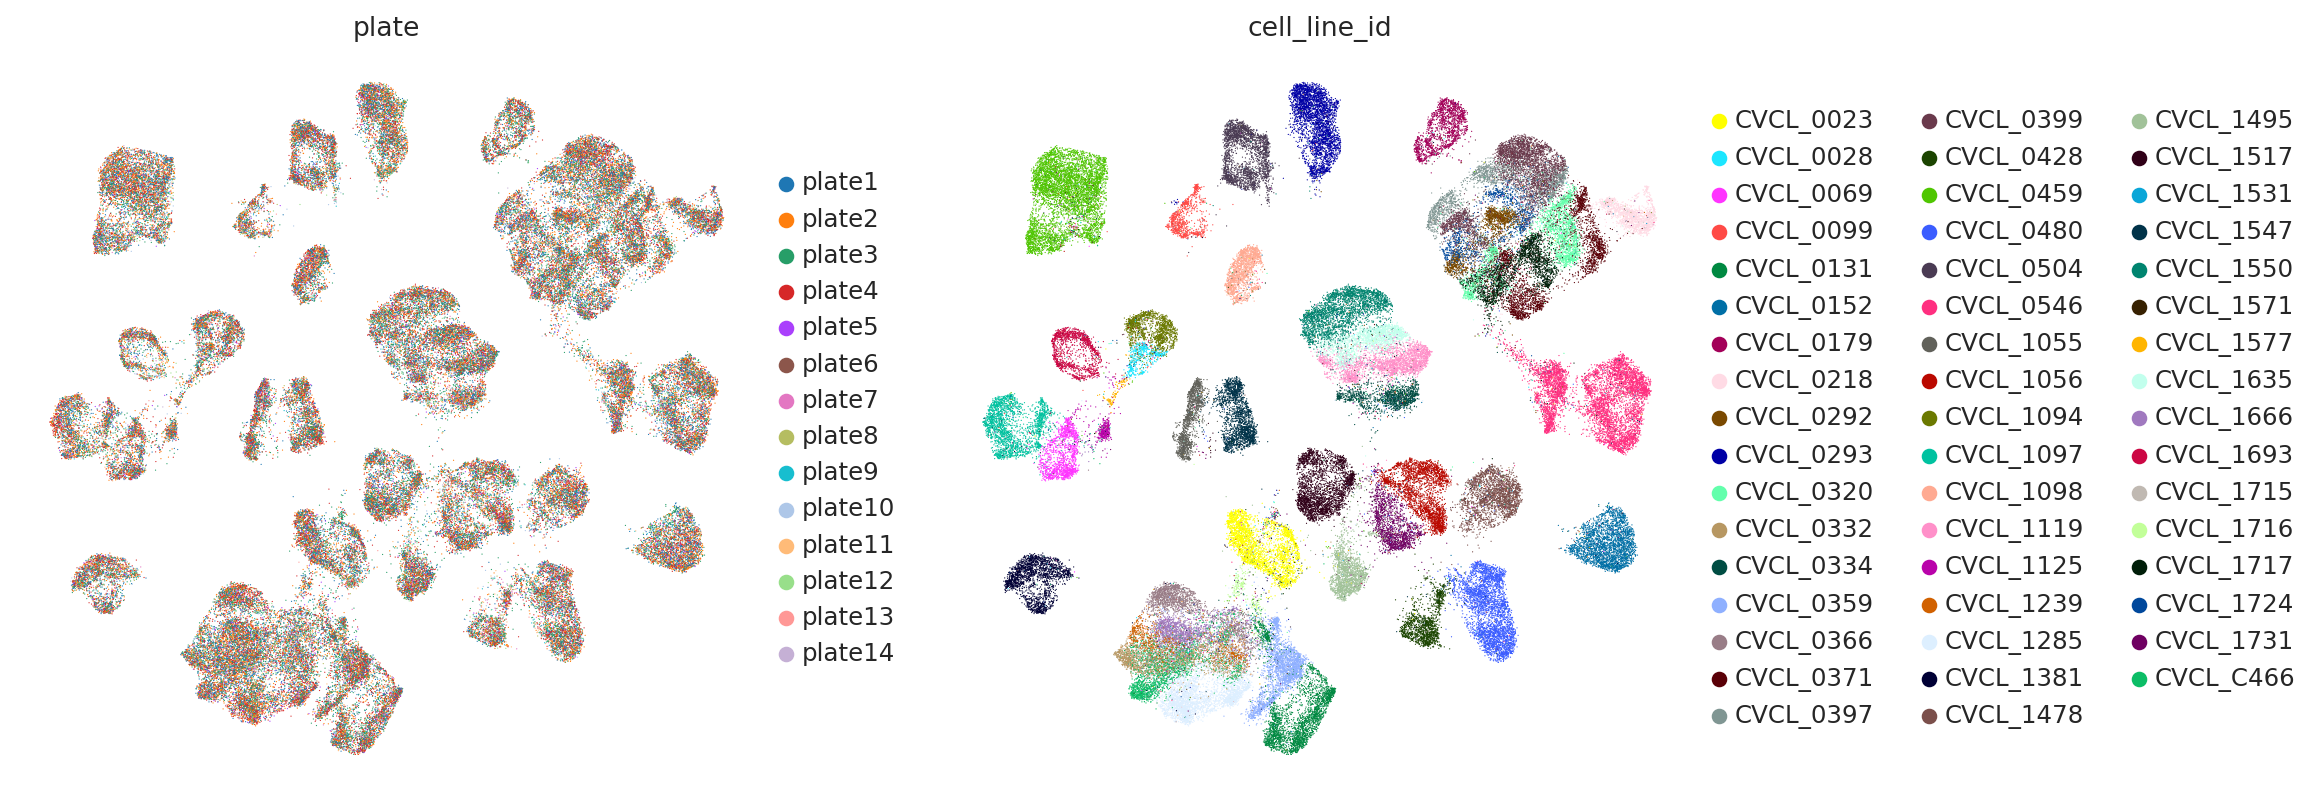

In [70]:
sc.pl.umap(
    adata_subsampled,
    color=["plate", "cell_line_id"],
    frameon=False,
    ncols=2,
)

We also didnt use the metadata

In [ ]:
# sc.pl.umap(
#    adata,
#    color=["moa-broad","phase"],
#    frameon=False,
#    ncols=2,
# )

In [ ]:
# sc.pl.umap(
#    adata,
#    color=["observed_lib_size","S_score","G2M_score"],
#    frameon=False,
#    ncols=3,
# )

## Compare results

In [72]:
from scib_metrics.benchmark import BatchCorrection, Benchmarker, BioConservation

In [ ]:
bm = Benchmarker(
    adata[list(np.random.choice(np.arange(adata.n_obs), size=10000, replace=False)), :],
    batch_key="plate",
    bio_conservation_metrics=BioConservation(
        isolated_labels=True,
        nmi_ari_cluster_labels_leiden=True,
        silhouette_label=True,
        clisi_knn=True,
        nmi_ari_cluster_labels_kmeans=True,
    ),
    batch_correction_metrics=BatchCorrection(
        bras=True,
        pcr_comparison=True,
        kbet_per_label=True,
        graph_connectivity=False,
        ilisi_knn=True,
    ),
    label_key="cell_line_id",
    embedding_obsm_keys=["X_mrVI_Torch_Lamin"],
    n_jobs=-1,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale=False)